# Import and Set Up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import glob
%cd ../

/mnt/c/Users/Daniel Yang/Desktop/Final_Project


In [2]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

# File Mangement and Helpers

In [ ]:
def writeToFile( solo_id, orch_id, segment_id, error_ls, hypdir):
    '''
    Argument: solo_id, orch_id, segment_id,: 
              identifying information for a solo segment 
              and an orchestra audio
              error_ls: the difference between prediction and ground truth 
              to be stored
              hypdir: name of folder for the file to be stored in
    Function: use pickle to dump the error list 
    '''
    if hypdir != None:
        experiment = "experiments/{}".format(hypdir)
        if not os.path.exists(experiment):
            os.mkdir(experiment)
        fname = "experiments/{}/{}-{}-{}.hyp".format(hypdir, solo_id, orch_id,segment_id)
        with open (fname, 'wb') as f:
            pkl.dump((error_ls),f)

In [ ]:
def get_piece():
    '''
    Return:
            a list of orchestra audio file name  
            a list of soloist audio file name
    '''
    solo_piece = [[] for i in range(4)]
    orch_piece = [[] for i in range(4)]
    for j in timeData:
        if j[2]=="s":
            solo_piece[int(j[1])-1].append(j)
        else:
            orch_piece[int(j[1])-1].append(j)
    return orch_piece, solo_piece

In [ ]:
def getAssignment():
    '''
    Return: 
            a list of all combinations of soloist segments 
            and orchestra reference tracks information 
            in the form of piece_id,segment_id,orch_id,solo_id
            where piece_id and segment_id are numbers 
            and orch_id and solo_id are the names of the audio files     
    '''
    assignment = []
    count = 0
    time_signature = [2,4,4,4]
    orch_piece, solo_piece  = get_piece()
    for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            #print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                
                assignment.append([piece_id,segment_id,orch_id,solo_id])
                
    return assignment

In [ ]:
def readHypFiles(hypdir):
    
    for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
        print(hypfile)
        with open(hypfile, "rb") as f:
            yield(pkl.load(f))

# Evaluating Segmental DTW Using Time Function

In [4]:
def evaluateBeatLevel(tf, solo_name, ref_name, sr=22050):
    # Only evaluate within segments
    diffs = []
    pieceName = solo_name.split('_')[0]
    gt_segments = queryInfo[pieceName]
    annotated_beats = list(timeData[ref_name].keys())
    for idx,beats in enumerate(gt_segments):
        beat1 = beats.split(',')[0][1:]
        beat2 = beats.split(',')[1][:-1]
        idx1 = annotated_beats.index(beat1)
        idx2 = annotated_beats.index(beat2)
        #offset = int(timeData[ref_name][beat1]*sr)-segment_predict[idx][0]
        #base_time = tf[segment_predict[idx][0]]
        base_time = tf[int(timeData[ref_name][beat1]*sr)]
        #print(offset)
        
        new_times = {}
        for i in range(idx1,idx2+1):
            key = annotated_beats[i]
            sample = tf[int(timeData[ref_name][key]*sr)]
            new_time = sample-base_time
            new_times[key]=new_time
            
        gt_beats = list(timeData[solo_name].keys())
        gt_base_time=timeData[solo_name][beat1]
        prev = 0
        prevgt = 0
        for idx, key in enumerate(new_times):
            if key in gt_beats:
                gt_time = (timeData[solo_name][key]-gt_base_time)*sr
                pred_time = new_times[key]
                #f idx != 0:
                #   print("diff",gt_time-prevgt, pred_time-prev)
                prev = pred_time
                prevgt = gt_time
                #rint(gt_time, pred_time)
                diffs.append(np.abs(gt_time-pred_time))
    return diffs

In [5]:
def evaluateBeatLevelFirst(tf, segment_predict, solo_name, ref_name, sr=22050):
    # Only evaluate within segments
    diffs = []
    pieceName = solo_name.split('_')[0]
    gt_segments = queryInfo[pieceName]
    annotated_beats = list(timeData[ref_name].keys())
    for idx,beats in enumerate(gt_segments):
        if idx!=1:
            continue
        beat1 = beats.split(',')[0][1:]
        beat2 = beats.split(',')[1][:-1]
        idx1 = annotated_beats.index(beat1)
        idx2 = annotated_beats.index(beat2)
        offset = int(timeData[ref_name][beat1]*sr)-segment_predict[idx][0]
        base_time = tf[segment_predict[idx][0]]
        
        new_times = {}
        for i in range(idx1,idx2+1):
            key = annotated_beats[i]
            sample = tf[int(timeData[ref_name][key]*sr)]
            new_time = sample-base_time
            new_times[key]=new_time
            
        gt_beats = list(timeData[solo_name].keys())
        gt_base_time=timeData[solo_name][beat1]
        prev = 0
        prevgt = 0
        for idx, key in enumerate(new_times):
            if key in gt_beats:
                gt_time = (timeData[solo_name][key]-gt_base_time)*sr
                pred_time = new_times[key]
                #f idx != 0:
                #   print("diff",gt_time-prevgt, pred_time-prev)
                prev = pred_time
                prevgt = gt_time
                #rint(gt_time, pred_time)
                diffs.append(np.abs(gt_time-pred_time))
    return diffs

In [6]:
def evaluateSegmentLevel(segment_predict, solo_name, ref_name, sr=22050):
    pieceName = solo_name.split('_')[0]
    gt_segments = queryInfo[pieceName]
    gt_samples = []
    diffs = []
    for beats in gt_segments:
        beat1 = beats.split(',')[0][1:]
        beat2 = beats.split(',')[1][:-1]
        sample1 = timeData[ref_name][beat1]*sr
        sample2 = timeData[ref_name][beat2]*sr
        gt_samples.append((sample1, sample2))
    for idx,segment in enumerate(segment_predict):
        seg0 = segment[0]
        seg1 = segment[1]
        diff0 = np.abs(gt_samples[idx][0]-seg0)
        diff1 = np.abs(gt_samples[idx][1]-seg1)
        diffs.append(diff0)
        diffs.append(diff1)
        if diff0 > 22050:
            print(solo_name, ref_name)
            print(gt_samples[idx][0],seg0)
        if diff1 > 22050:
            print(ref_name, solo_name)
            print(gt_samples[idx][1],seg1)
        #print((gt_samples[idx][0]-seg0)/(sr*sr))
    return diffs, gt_samples, segment_predict

In [7]:
def evaluateTF(hypdir, hop_length=512, sr=22050):
    '''
    Evaluate Time Function
    '''
    times = []
    segment_tolerances =[1, 0.5, 0.25]
    segment_total = np.zeros(len(segment_tolerances))
    segment_correct = np.zeros(len(segment_tolerances))
    
    beat_tolerances =np.arange(0.0, 2, 0.025)
    #beat_tolerances=[0.25]
    beat_total = np.zeros(len(beat_tolerances))
    beat_correct = np.zeros(len(beat_tolerances))
    beat_totalFirst = np.zeros(len(beat_tolerances))
    beat_correctFirst = np.zeros(len(beat_tolerances))
    for solo_name, ref_name, tf, segment_predict, time_taken in readHypFiles(hypdir):
        tf = np.array(tf)
        segment_predict = np.array(segment_predict)*hop_length
        #print(segment_predict)
        segment_diffs, gt_samples, segment_predict = evaluateSegmentLevel(segment_predict, solo_name, ref_name)
        if any(tf!=None):
            beat_diffs = evaluateBeatLevel(tf, solo_name, ref_name)
            beat_diffsFirst = evaluateBeatLevelFirst(tf, segment_predict, solo_name, ref_name)
            #beat_diffs = evaluateDiffLevel(tf, segment_predict, solo_name, ref_name)
            beat_diffs =(np.array(beat_diffs)/sr)
            beat_diffsFirst =(np.array(beat_diffsFirst)/sr)
        segment_diffs =np.array(segment_diffs)/sr
        times.append(time_taken)
        
        #Update Segment Level Accuracy
        for idx, tolerance in enumerate(segment_tolerances):
            segment_correct[idx] += np.sum(np.where(segment_diffs<tolerance, 1, 0))
            segment_total[idx]+=len(segment_diffs)
            
            
        if any(tf!=None):
            #Update Beat Level Accuracy
            for idx, tolerance in enumerate(beat_tolerances):
                beat_correct[idx] += np.sum(np.where(beat_diffs<tolerance, 1, 0))
                beat_total[idx]+=len(beat_diffs)

            #Update First Beat Level Accuracy
            for idx, tolerance in enumerate(beat_tolerances):
                beat_correctFirst[idx] += np.sum(np.where(beat_diffsFirst<tolerance, 1, 0))
                beat_totalFirst[idx]+=len(beat_diffsFirst)
    print("hop_length", hop_length)
    print(segment_correct/segment_total)
    print(beat_correct/beat_total)
    return segment_correct/segment_total, beat_correct/beat_total, times   

In [8]:
seg_accuracy, beat_accuracy, times = evaluateTF("experiments/expFinal", hop_length=512)
#seg_accuracy, beat_accuracy = evaluate("baselines/debug2")

experiments/expFinal/p1s_perf12-p1f_perf16.hyp
experiments/expFinal/p1s_perf12-p1f_perf2.hyp
p1f_perf2 p1s_perf12
3928012.66666305 3983360
experiments/expFinal/p1s_perf12-p1f_perf23.hyp
p1f_perf23 p1s_perf12
3797529.00000075 3849216
experiments/expFinal/p1s_perf12-p1f_perf24.hyp
experiments/expFinal/p1s_perf12-p1f_perf6.hyp
p1f_perf6 p1s_perf12
3799099.9999963506 3838976
experiments/expFinal/p1s_perf2-p1f_perf16.hyp
experiments/expFinal/p1s_perf2-p1f_perf2.hyp
experiments/expFinal/p1s_perf2-p1f_perf23.hyp
experiments/expFinal/p1s_perf2-p1f_perf24.hyp
experiments/expFinal/p1s_perf2-p1f_perf6.hyp
experiments/expFinal/p1s_perf25-p1f_perf16.hyp
p1f_perf16 p1s_perf25
3888554.6666641505 3974144
experiments/expFinal/p1s_perf25-p1f_perf2.hyp
p1f_perf2 p1s_perf25
3928012.66666305 4083712
experiments/expFinal/p1s_perf25-p1f_perf23.hyp
p1f_perf23 p1s_perf25
3797529.00000075 3882496
experiments/expFinal/p1s_perf25-p1f_perf24.hyp
p1f_perf24 p1s_perf25
3493643.6666648993 3522560
p1f_perf24 p1s_perf2

/home/dyang/anaconda3/envs/MIR5/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


experiments/expFinal/p2s_perf17-p2f_perf14.hyp
experiments/expFinal/p2s_perf17-p2f_perf18.hyp
p2f_perf18 p2s_perf17
1304883.6666684 1280000
p2f_perf18 p2s_perf17
5317967.9999963995 5291008
experiments/expFinal/p2s_perf17-p2f_perf20.hyp
experiments/expFinal/p2s_perf17-p2f_perf5.hyp
p2f_perf5 p2s_perf17
4821841.6666623 4788736
experiments/expFinal/p2s_perf4-p2f_perf1.hyp
p2f_perf1 p2s_perf4
1345851.3333310501 1297408
experiments/expFinal/p2s_perf4-p2f_perf14.hyp
experiments/expFinal/p2s_perf4-p2f_perf18.hyp
p2f_perf18 p2s_perf4
5317967.9999963995 5287424
experiments/expFinal/p2s_perf4-p2f_perf20.hyp
experiments/expFinal/p2s_perf4-p2f_perf5.hyp
p2f_perf5 p2s_perf4
3153074.3333375994 3209216
p2f_perf5 p2s_perf4
4821841.6666623 4794880
experiments/expFinal/p2s_perf8-p2f_perf1.hyp
p2f_perf1 p2s_perf8
1345851.3333310501 1321984
experiments/expFinal/p2s_perf8-p2f_perf14.hyp
p2f_perf14 p2s_perf8
5230606.3333377 5207040
experiments/expFinal/p2s_perf8-p2f_perf18.hyp
p2f_perf18 p2s_perf8
1304883.6

/home/dyang/anaconda3/envs/MIR5/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


experiments/expFinal/p3s_perf22-p3f_perf16.hyp
experiments/expFinal/p3s_perf22-p3f_perf2.hyp
experiments/expFinal/p3s_perf22-p3f_perf23.hyp
experiments/expFinal/p3s_perf22-p3f_perf24.hyp
experiments/expFinal/p3s_perf9-p3f_perf11.hyp
experiments/expFinal/p3s_perf9-p3f_perf16.hyp
experiments/expFinal/p3s_perf9-p3f_perf2.hyp
p3s_perf9 p3f_perf2
3455676.3333372 3425280
experiments/expFinal/p3s_perf9-p3f_perf23.hyp
experiments/expFinal/p3s_perf9-p3f_perf24.hyp
experiments/expFinal/p4s_perf15-p4f_perf13.hyp
p4s_perf15 p4f_perf13
204395.33332680003 1395712
p4f_perf13 p4s_perf15
1369877.33333535 2529792
experiments/expFinal/p4s_perf15-p4f_perf16.hyp
p4s_perf15 p4f_perf16
18244.666661550003 1144832
p4f_perf16 p4s_perf15
1116649.33333275 2265088
experiments/expFinal/p4s_perf15-p4f_perf2.hyp
experiments/expFinal/p4s_perf2-p4f_perf13.hyp
p4s_perf2 p4f_perf13
204395.33332680003 1395200
p4f_perf13 p4s_perf2
1369877.33333535 2530304
experiments/expFinal/p4s_perf2-p4f_perf16.hyp
p4s_perf2 p4f_perf16
1

In [109]:
seg_accuracy, beat_accuracy, times = evaluateTF("experiments/expTest8")

experiments/expTest8/p1s_perf12-p1f_perf16.hyp
experiments/expTest8/p1s_perf12-p1f_perf2.hyp
p1f_perf2 p1s_perf12
3928012.66666305 3982336
experiments/expTest8/p1s_perf12-p1f_perf23.hyp
p1f_perf23 p1s_perf12
3797529.00000075 3852288
experiments/expTest8/p1s_perf12-p1f_perf24.hyp
experiments/expTest8/p1s_perf12-p1f_perf6.hyp
p1f_perf6 p1s_perf12
3799099.9999963506 3838976
experiments/expTest8/p1s_perf2-p1f_perf16.hyp
experiments/expTest8/p1s_perf2-p1f_perf2.hyp
experiments/expTest8/p1s_perf2-p1f_perf23.hyp
experiments/expTest8/p1s_perf2-p1f_perf24.hyp
experiments/expTest8/p1s_perf2-p1f_perf6.hyp
experiments/expTest8/p1s_perf25-p1f_perf16.hyp
p1f_perf16 p1s_perf25
3888554.6666641505 3962880
experiments/expTest8/p1s_perf25-p1f_perf2.hyp
p1f_perf2 p1s_perf25
3928012.66666305 4083712
experiments/expTest8/p1s_perf25-p1f_perf23.hyp
p1f_perf23 p1s_perf25
3797529.00000075 3882496
experiments/expTest8/p1s_perf25-p1f_perf24.hyp
p1f_perf24 p1s_perf25
3493643.6666648993 3522560
p1f_perf24 p1s_perf2

# Evaluate Temporal DTW Using Inverse Time Function

In [1]:
def evalITF(piece_id,segment_id,orch_id,solo_id):
    '''
    Argument: identifying info for a solo segment and a reference audio
    Return:   a list consisted of difference in seconds 
              between prediction and ground truth 
    '''
    query_len = .5
    
    diff_ls = []
    
    time_signature = [2,4,4,4]
    
    segment_info = queryInfo['p'+str(piece_id+1)+'s']
    segment = []
    for raw_seg in segment_info:
        start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
        segment.append([start,end])
    
    start, end = segment[segment_id]
    query_list = []
    query_index = start
    while query_index != end:            
        query_list.append(query_index)
        measure = int(query_index[:query_index.index('.')])
        beat = int(query_index[query_index.index('.')+1:])
        if beat == time_signature[piece_id]:
            beat = 1
            measure+=1
            query_index = str(measure)+"."+str(beat)
        else:
            beat+=1
            query_index = str(measure)+"."+str(beat)
            query_list.append(query_index)
    
    
    ref_audio,solo_audio = audioFiles[orch_id],audioFiles[solo_id][segment_id]
    
    first_query = query_list[0]
    
    orch_time_data,solo_time_data = timeData[orch_id],timeData[solo_id]
    
    orch_start_time, solo_start_time = orch_time_data[first_query], solo_time_data[first_query]
    orch_end_time = orch_time_data[query_list[-1]]
    est_ref_start_time, est_ref_end_time = max(orch_start_time - 1,0),orch_end_time+1
    
    tDTW = temporalDTW(ref_audio)
    tDTW.newSeg(est_ref_start_time, est_ref_end_time)
    
    itf_ls = []
    
    for query_sec in range(0, len(solo_audio), int(query_len*sr) ):
        

        
        input_audio = solo_audio[int(query_sec):int(query_sec+query_len*sr)]
        
        if len(input_audio) < 1:
            print("input audio too short")
        
        #print(len(input_audio)/sr, orch_start_time)
        
        itf, wp = tDTW.align(input_audio)
        
        #return itf,wp
        
        itf_ls.extend(itf)
        
    itf_ls = np.array(itf_ls)
    
    #print(itf_ls.shape)
    
    duplicate_set = set()
    

    
    for idx, query in enumerate(query_list):
        solo_input_sec = solo_time_data[query] 
        orch_output_sec = orch_time_data[query]
        
        if math.isnan(solo_input_sec) or math.isnan(orch_output_sec):
            continue
        
        solo_input_sec -=  solo_start_time
        solo_input_idx = int(solo_input_sec * sr)
        
        ground_truth = orch_output_sec * sr
        
        if solo_input_sec in duplicate_set:
            continue
        else:
            duplicate_set.add(solo_input_sec)
    
        if solo_input_idx >= len(itf_ls):
            print("index too large")
            continue
        
        prediction = itf_ls[solo_input_idx]
        

        
        diff =  ground_truth - prediction 
        
        if (abs(diff/sr) > 1.2 and debug) or (abs(diff/sr)>5): 
            print( piece_id,segment_id,orch_id,solo_id, idx )
            print("    ",diff/sr,"    ", ground_truth/sr,prediction/sr)
        
        diff_ls.append(diff)
        
        #print(prediction/sr, ground_truth/sr, diff/sr,solo_input_sec)
    
    return diff_ls#, itf_ls

In [ ]:
def evalITFAll(hypdir, restart=False):
    '''
    Argument: hydir: folder to store results
              restart: can over write if True
    '''
    diff_ls = []
    assignment = getAssignment(1)
    for assignment_idx in range(len(assignment)):
        
        piece_id,segment_id,orch_id,solo_id = assignment[assignment_idx]
        print(assignment_idx,piece_id,segment_id,orch_id,solo_id)
        outfile = 'experiments/{}/{}-{}-{}.hyp'.format(hypdir, solo_id, orch_id,segment_id)
        if os.path.exists(outfile) and not restart:
            print("Skipped: {}".format(outfile))
            with open(outfile, 'rb') as f:
                diff=pkl.load(f)
            if len(diff)>1:
                diff_ls.extend(np.array(diff))
        else:
            diff = evalITF(piece_id,segment_id,orch_id,solo_id)
            writeToFile( solo_id, orch_id, segment_id,diff, hypdir)
            if len(diff)>1:
                diff_ls.extend(np.array(diff))
        
        if assignment_idx%10 == 0 :
            print()
            print()
            diff_present = np.array(diff_ls).reshape((-1,))/sr
            #errorTemplate = lambda tolerance: (np.sum(np.where(np.abs(diff_present)< float(tolerance), 1, 0)))/len(diff_present)
            errorHalf = (np.sum(np.where(np.abs(diff_present)< .5, 1, 0)))/len(diff_present)
            error1s = (np.sum(np.where(np.abs(diff_present)<1, 1, 0)))/len(diff_present)
            error2s = (np.sum(np.where(np.abs(diff_present)< 2, 1, 0)))/len(diff_present)
            print("result",assignment_idx, assignment[assignment_idx])
            print(errorHalf,error1s,error2s)
            plt.plot(diff_present)
            print()
    diff_present = np.array(diff_ls).reshape((-1,))/sr
    errorHalf = (np.sum(np.where(np.abs(diff_present)< .5, 1, 0)))/len(diff_present)
    error1s = (np.sum(np.where(np.abs(diff_present)<1, 1, 0)))/len(diff_present)
    error2s = (np.sum(np.where(np.abs(diff_present)< 2, 1, 0)))/len(diff_present)
    print("result",assignment_idx, assignment[assignment_idx])
    print(errorHalf,error1s,error2s)
    plt.plot(diff_present)
    return diff_present

# Plot Helpers

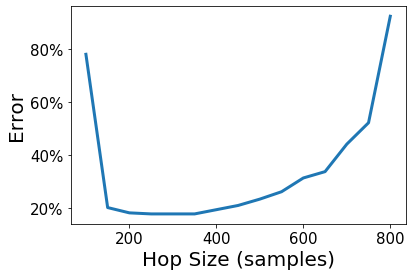

In [123]:
plt.rcParams.update({'font.size': 15})
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.xlabel('Hop Size (samples)', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.plot(x,y, linewidth=3)

In [22]:
beat_y = beat_accuracy
beat_x = np.arange(0.05, 2, 0.05)

Text(0, 0.5, 'Error')

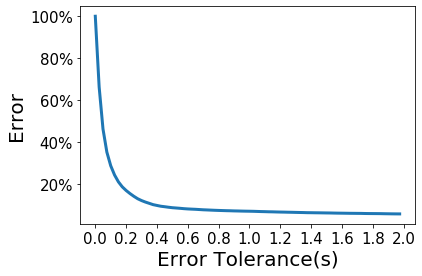

In [58]:
x=np.arange(0.0, 2, 0.025)
plt.rcParams.update({'font.size': 15})
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot(x, 1-np.array(beat_accuracy), linewidth=3)
plt.xticks(np.arange(min(x), max(x)+.1, 0.2))
plt.xlabel('Error Tolerance(s)', fontsize=20)
plt.ylabel('Error', fontsize=20)

# Other

Text(0.5, 1.0, 'Sorted Solo Segment Lengths in Seconds')

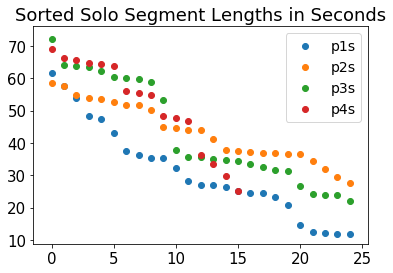

In [70]:
beats = {}
for key in queryInfo:
    if 's' in key:
        data = queryInfo[key]
        for segment in data:
            beat1 = segment.split(",")[0][1:]
            beat2 = segment.split(",")[1][:-1]
            if key in beats:
                beats[key].append((beat1,beat2))
            else:
                beats[key] = [(beat1,beat2)]
times={}
for key in timeData:
    pieceName = key.split("_")[0]
    if 's' in pieceName:
        for beat1, beat2 in beats[pieceName]:
            t1 = timeData[key][beat1]
            t2 = timeData[key][beat2]
            if pieceName in times:
                times[pieceName].append(t2-t1)
            else:
                times[pieceName]=[t2-t1]
for key in times:
    plt.scatter(np.arange(len(times[key])),sorted(times[key])[::-1], label = '{}'.format(key))
plt.legend(loc="upper right",fontsize = 14)
plt.title("Sorted Solo Segment Lengths in Seconds")